

Reikia padaryti analitini modeli pirmam straipsniui
Turi parinkti opt konfig (P_E, P_C, N_E, N_C), pagal C, T_W, ir T_B

<p style='background:gray'>
<img src="DataFlowModel2.svg">
</p>

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

def Model(Lambda,P_E,P_C,N_E,mu_e1,N_C,mu_c1):
    if N_E == 0:
        p_e = 0
        P_C = 1
        if N_C == 0:
            p_c = 0
        else:
            p_c = 1/N_C
    else:
        p_e = 1/N_E
    if N_C == 0:
        p_c = 0
        P_E = 1
        if N_E == 0:
            p_e = 0
        else:
            p_e = 1/N_E    
    else:
        p_c = 1/N_C
    
    mu_e = mu_e1;
    mu_c = mu_c1;
    lambda_e = P_E*p_e*Lambda
    lambda_c = P_C*p_c*Lambda
    ro_e = lambda_e/mu_e
    ro_c = lambda_c/mu_c
    sys_stable = True
    if ro_e >= 1 or ro_c >= 1:
        # print("ro_e and ro_c must be < 1")
        sys_stable = False

    # W_e(i) and W_c(j) waiting time in queues for i-th Edge device and j-th
    # Cloud server. Waiting time in queue depends on distribution of time
    # intervals between the measurements or time moments of initiated requests
    # of data processing, and the distribution of data processing durations.
    # If requests of data processing arrive according Poison
    # process (time intervals between requests are distributed according exponential distribution), 
    # and data processing time is determined (constant), then waiting times in
    # queues can be estimated using M/D/1 model:
    W_e = ro_e/(2*mu_e*(1-ro_e))
    W_c = ro_c/(2*mu_c*(1-ro_c))
    T_e = 1/mu_e + W_e
    T_c = 1./mu_c + W_c
    if P_E != 0 and N_E == 0: T_e = np.inf 
    if P_C != 0 and N_C == 0: T_c = np.inf 
    if P_E == 0 and N_E == 0: T_e = 0 
    if P_C == 0 and N_C == 0: T_c = 0
    if P_E == 0 and N_E != 0: T_e = np.inf
    if P_C == 0 and N_C != 0: T_c = np.inf
    return W_e,T_e,W_c,T_c,ro_e,ro_c,sys_stable

    

In [115]:
import warnings
warnings.filterwarnings('ignore')

# Lambda_list = [500,1000]
Lambda_list = range(50,2050,50)

# Select type of Edge devices
# Edge_devices = ["Sams_A13_5G","MB_Air_M1"]
# Edge_devices = ["Sams_A13_5G"]
Edge_devices = ["MB_Air_M1"]
# edge_devices = "MacBook Air M1"

# Select pricing option:
# cloud_pricing = "On-demand capacity"
# Cloud_pricing = ["Dedicated","On_demand"]
Cloud_pricing = ["Dedicated"]
# Cloud_pricing = ["On_demand"]

# For config finding
# P_E_start = 0
P_E_step = 0.01#0.25
# P_E_stop = 1
N_E_range = [20]#range(0,101)
N_C_range = [20]#range(0,101)

# ------------------------------------------------

T_W_max_sec = 300
T_B_min_h = 8
opt_results = []
# -----------------------

for Lambda in Lambda_list:
    for edge_device in Edge_devices:
        for cloud_pricing in Cloud_pricing:
            print('Lambda:',Lambda,', Edge:',edge_device,', Pricing:',cloud_pricing)
            if edge_device == "Sams_A13_5G":
                tProc_E_sec = 200.44 # Samsung A13 5G
                C_E = 180.99/24 # Eur/month - Samsung A13 5G
                N_P = 200 # Samsung A13 5G

            if edge_device == "MB_Air_M1":
                tProc_E_sec = 28.03 # MacBook Air M1
                C_E = 999/24 # Eur/month - MacBook Air M1
                N_P = 400 # MacBook Air M1

            # Cloud pricing strategy (Capacity Types)
            # https://docs.oracle.com/en-us/iaas/Content/Compute/Concepts/capacity-types.htm
            # On-demand capacity: Pay for only the compute capacity that you use.
            # Dedicated capacity: Run VM instances on dedicated servers that are a single tenant and not shared with other customers.

            C_C = 29.55 # Eur/month - Oracle VM
            tProc_C_sec = 106.94 # Oracle VM
            #------------------------------------------------
            tProc_E = tProc_E_sec/3600 
            tProc_E = tProc_C_sec/3600 # h
            mu_e1 = 1/tProc_E 
            mu_c1 = 1/tProc_E

            # Brute force method to calculate for all configurations

            columns = ['P_E', 'P_C', 'N_E','N_C','ro_E','ro_C','C_EurMonth','T_B_h','T_E_sec','T_C_sec','T_W_sec']
            df = pd.DataFrame(columns=columns)

            # for pe in np.arange(P_E_start,P_E_stop+P_E_step,P_E_step):
            for P_E in np.arange(0,1+P_E_step,P_E_step):
                for N_E in N_E_range:
                    for N_C in N_C_range:
                        W_E,T_E,W_C,T_C,ro_E,ro_C,sys_stable = Model(Lambda,P_E,1-P_E,N_E,mu_e1,N_C,mu_c1)
                        # if nc == 0:
                        #     P_E = 1
                        # else:
                        #     P_E = pe
                        P_C = 1 - P_E
                        T_W = (P_E*T_E+P_C*T_C)*3600
                        if P_E == 0: T_W = T_C*3600
                        if P_C == 0: T_W = T_E*3600

                        if cloud_pricing == "On_demand":
                            C_S = N_E*C_E + N_C*C_C*ro_C
                            if P_E == 0: C_S = N_C*C_C*ro_C
                        if cloud_pricing == "Dedicated":
                            C_S = N_E*C_E + N_C*C_C
                            if P_E == 0: C_S = N_C*C_C

                        if P_C == 0: C_S = N_E*C_E
                        if ro_E == 0:
                            T_B = np.inf
                        else:
                            T_B = N_P*tProc_E_sec/ro_E/3600
                        if sys_stable == True and T_E*3600 < T_W_max_sec and T_C*3600 < T_W_max_sec and T_B > T_B_min_h: # jei bat laikas svarbus 
                        # if sys_stable == True and T_W < T_W_max_sec and T_B > T_B_min_h: # jei bat laikas svarbus 
                        # if ro_E < 1 and ro_C < 1 and T_E*3600 < T_W_max_sec and T_C*3600 < T_W_max_sec: # jei bat laikas nesvarbus 
                        # if ro_E < 1 and ro_C < 1 and T_B > T_B_min_h: # jei bat laikas svarbus o laukimo ne 
                        # if ro_E < 1 and ro_C < 1 and T_W < T_W_max_sec and T_B > T_B_min_h:        
                            new_row = [P_E,1-P_E,N_E,N_C,ro_E,ro_C,C_S,T_B,T_E*3600,T_C*3600,T_W]
                            df = df.append(pd.Series(new_row, index=df.columns), ignore_index=True)

            # Finds optimal by sorting
            # min_cols = ['C_EurMonth','T_W_sec','T_B_h']
            # min_cols = ['T_B_h','C_EurMonth','N_C','N_E']
            # min_cols = ['C_EurMonth','T_B_h','N_C','N_E']
            min_cols = ['T_B_h','C_EurMonth']
            # min_cols = ['C_EurMonth','T_E_sec']
            # min_cols = ['C_EurMonth','T_B_h','N_E','N_C']
            # min_cols = ['C_EurMonth','N_E','N_C','T_B_h']
            # min_cols = ['C_S','N_E','N_C','T_B']
            #min_cols = ['C_S']
            # df_sorted = df.sort_values(by=min_cols, ascending=[True, True,True, True])
            # df_sorted = df.sort_values(by=min_cols, ascending=[True, True,True])
            df_sorted = df.sort_values(by=min_cols, ascending=[True, True])
            # df_sorted = df.sort_values(by=min_cols, ascending=[True])

            # print(df_sorted)

            # print('--------------')
            # print 
            # print(df_sorted.head(1))

            # opt_config = df_sorted.iloc[0].to_dict()
            try:
                opt_config = df_sorted.head(1).iloc[0].to_dict()
                opt_config['Lambda'] = Lambda
                opt_config['Edge'] = edge_device
                opt_config['CloudPricing'] = cloud_pricing
                opt_results.append(opt_config)
                print(opt_config)
            except IndexError:
                print("Max Lambda for crit T_W reached")
                # break
                # pass

            # print(opt_config)
            


# for result in opt_results:
#     print(result)

# np.save("OptResultsAgricultureStraipsniui_Tw300_Tbat8h_2", opt_results,allow_pickle=True)

Lambda: 50 , Edge: MB_Air_M1 , Pricing: Dedicated
{'P_E': 0.99, 'P_C': 0.010000000000000009, 'N_E': 20.0, 'N_C': 20.0, 'ro_E': 0.07352125, 'ro_C': 0.0007426388888888895, 'C_EurMonth': 1423.5, 'T_B_h': 42.361146531709466, 'T_E_sec': 111.18314236834898, 'T_C_sec': 106.97973841267952, 'T_W_sec': 111.14110832879228, 'Lambda': 50, 'Edge': 'MB_Air_M1', 'CloudPricing': 'Dedicated'}
Lambda: 100 , Edge: MB_Air_M1 , Pricing: Dedicated
{'P_E': 0.99, 'P_C': 0.010000000000000009, 'N_E': 20.0, 'N_C': 20.0, 'ro_E': 0.1470425, 'ro_C': 0.001485277777777779, 'C_EurMonth': 1423.5, 'T_B_h': 21.180573265854733, 'T_E_sec': 116.15776580310273, 'T_C_sec': 107.01953593573566, 'T_W_sec': 116.06638350442907, 'Lambda': 100, 'Edge': 'MB_Air_M1', 'CloudPricing': 'Dedicated'}
Lambda: 150 , Edge: MB_Air_M1 , Pricing: Dedicated
{'P_E': 0.99, 'P_C': 0.010000000000000009, 'N_E': 20.0, 'N_C': 20.0, 'ro_E': 0.22056375, 'ro_C': 0.0022279166666666684, 'C_EurMonth': 1423.5, 'T_B_h': 14.120382177236488, 'T_E_sec': 122.0708637

0     42.361147
1     21.180573
2     14.120382
3     10.590287
4      8.472229
5      8.034011
6      8.096049
7      8.064911
8      8.034011
9      8.064911
10     8.111709
11     8.127429
12     8.064911
13     8.096049
14     8.223046
Name: T_B_h, dtype: float64


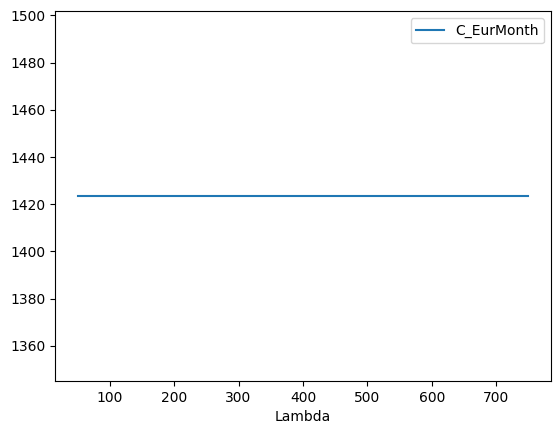

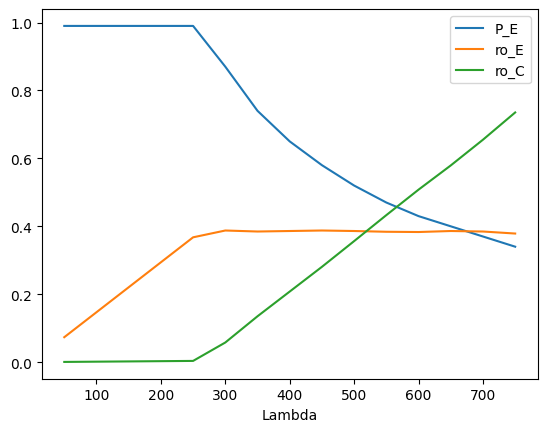

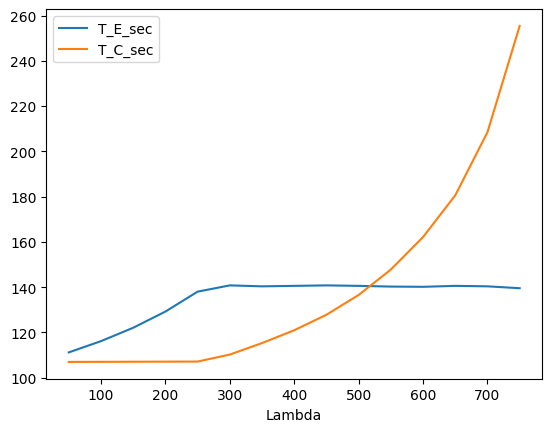

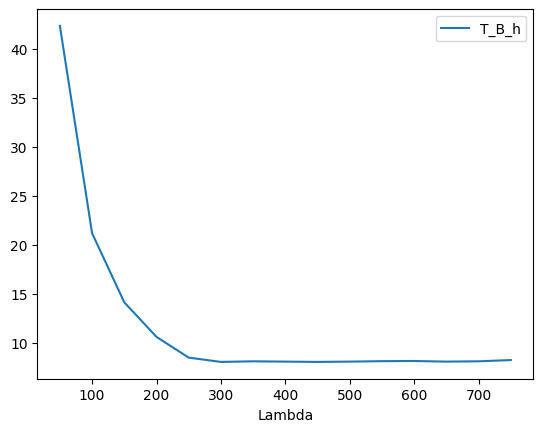

In [116]:
df_for_analysis = pd.DataFrame(opt_results)
df_for_analysis

df_for_analysis.plot("Lambda","C_EurMonth")

df_for_analysis.plot("Lambda",["P_E","ro_E","ro_C"])
df_for_analysis.plot("Lambda",["T_E_sec","T_C_sec"])
df_for_analysis.plot("Lambda","T_B_h")
print(df_for_analysis["T_B_h"])

In [117]:
# x = np.load("OptResultsAgricultureStraipsniui.npy",allow_pickle=True)
# print(x)